# A programming introduction to GANs

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

## Introduction


This is a post about Generative Adversarial Networks (GANs). This post is very heavily influenced and borrows code from:

- [Video from Luis Serrano](https://www.youtube.com/watch?v=8L11aMN5KY8)
- Heavily borrowed code from this [article]( https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) on machine learning mastery


These folks deserve all the credit! I am writing this post mostly for my learning.

## Goal

The goal of GANs is to generate [realistic data](), i.e. data with similar statistics as the training data. 

See below a "generated" face on https://thispersondoesnotexist.com

These are people that do not exist but their faces have been generated using GANs.

In [7]:
from IPython.display import HTML, IFrame
IFrame("https://thispersondoesnotexist.com", 400, 400)

## Overall Block Diagram

Conceptually, GANs are simple.They have two main components:

- A discriminator: that tries to accurately tell generated and real data (from training data) apart
- A generator: that generated data given some random numbers

The goal of GANs is to use the generator to create realistic data such that the discriminator thinks it is real (coming from the training dataset)


![](GAN-1.jpg)

The two components discriminator and generator are "fighting" where:

- the goal of the discriminator is to tell apart fake (generated) data from true data (from training set) even when the generator is fairly good
- the goal of the generator is to generate realistics data such that the discriminator thinks it is real data

![](GAN-2.jpg)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mediapy as media

%matplotlib inline
np.random.seed(40)

In [29]:
SIZE = 5000
faces = np.vstack((np.random.uniform(0.8, 1, SIZE), 
                   np.random.uniform(0., 0.1, SIZE),
                  np.random.uniform(0., 0.1, SIZE),
                  np.random.uniform(0.8, 1, SIZE))).T
faces.shape

(5000, 4)

In [30]:
def plot_face(f):
    f_reshape = f.reshape(2, 2)
    plt.imshow(f_reshape, cmap="Greys")

In [31]:
def plot_faces(faces, subset=1):
    images = {
        f'Image={im}': faces[im].reshape(2, 2)
        for im in range(len(faces))[::subset]
    }
    media.show_images(images, border=False, columns=8, height=80, cmap='Greys')

plot_faces(faces, subset=700)

Image=0,Image=700,Image=1400,Image=2100,Image=2800,Image=3500,Image=4200,Image=4900


In [32]:

# Examples of noisy images
noise = np.random.randn(40, 4)
noise = np.abs(noise)
noise = noise/noise.max()

In [33]:
plot_faces(noise)

Image=0,Image=1,Image=2,Image=3,Image=4,Image=5,Image=6,Image=7
Image=8,Image=9,Image=10,Image=11,Image=12,Image=13,Image=14,Image=15
Image=16,Image=17,Image=18,Image=19,Image=20,Image=21,Image=22,Image=23
Image=24,Image=25,Image=26,Image=27,Image=28,Image=29,Image=30,Image=31
Image=32,Image=33,Image=34,Image=35,Image=36,Image=37,Image=38,Image=39


In [34]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

discriminator = Sequential([
  Dense(1,activation='sigmoid', input_shape=(4, )),
])

discriminator._name = "Discriminator"

discriminator.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy'
)


In [35]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [49]:
from keras.layers import ReLU
generator = Sequential([
  Dense(4, input_shape=(1, )),
   ReLU(max_value=1.0) 

])

generator._name = "Generator"

generator.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy'
)



In [50]:
generator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 8         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 4)                 0         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


In [51]:
import tensorflow as tf

In [52]:
#X, y = vstack((noise, X_fake)), vstack((y_real, y_fake))

discriminator.train_on_batch(noise, np.zeros(noise.shape[0]))
discriminator.train_on_batch(faces, np.ones(faces.shape[0]))

0.7149367928504944

In [53]:
discriminator.weights

[<tf.Variable 'dense_2/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[ 0.22760226],
        [-0.1447369 ],
        [-0.1821059 ],
        [-0.443985  ]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.1692846], dtype=float32)>]

In [54]:
def gen_fake(n_samples):
    x_input = np.random.randn(n_samples, 1)
    # predict outputs
    X = generator.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

In [55]:
plot_faces(gen_fake(20)[0])

In [56]:
def gen_real(n_samples):
    # choose random instances
    ix = np.random.randint(0, faces.shape[0], n_samples)
    # retrieve selected images
    X = faces[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

In [57]:
plot_faces(gen_real(20)[0])

In [58]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [59]:
gan_model = define_gan(generator, discriminator)

/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


![](GAN-3.jpg)

In [60]:
samples_saved = {}
losses = {}
N_ITER = 2000
STEP = N_ITER//10
for i in range(N_ITER):
    # Generate some fake data
    X_fake, y_fake = gen_fake(5)
    X_real, y_real = gen_real(5)
    
    X, y = np.vstack((X_fake, X_real)), np.vstack((y_fake, y_real))
    
    # Discriminator 
    d_loss = discriminator.train_on_batch(X, y)
        
    # Generator
    n_samples = 10
    g_loss= gan_model.train_on_batch(np.random.randn(n_samples, 1), np.ones(n_samples))
    losses[i] = {'g':g_loss, 'd':d_loss}
    
    # Save 5 samples
    samples_saved[i]= gen_fake(5)[0]
    
    if i%STEP==0:
        print("")
        print("Iteration: {}".format(i))
        
        print("Discriminator loss: {:0.2f}".format(d_loss))


        print("Generator loss: {:0.2f}".format(g_loss))




Iteration: 0
Discriminator loss: 0.74
Generator loss: 0.63

Iteration: 200
Discriminator loss: 0.69
Generator loss: 0.63

Iteration: 400
Discriminator loss: 0.72
Generator loss: 0.55

Iteration: 600
Discriminator loss: 0.58
Generator loss: 0.67

Iteration: 800
Discriminator loss: 0.68
Generator loss: 0.59

Iteration: 1000
Discriminator loss: 0.66
Generator loss: 0.68

Iteration: 1200
Discriminator loss: 0.68
Generator loss: 0.56

Iteration: 1400
Discriminator loss: 0.66
Generator loss: 0.78

Iteration: 1600
Discriminator loss: 0.72
Generator loss: 0.70

Iteration: 1800
Discriminator loss: 0.70
Generator loss: 0.66


<AxesSubplot:>

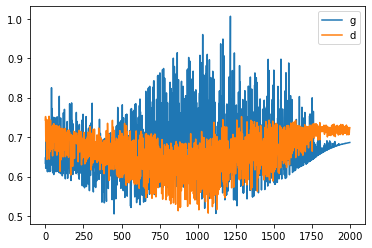

In [61]:
import pandas as pd
losses_df = pd.DataFrame(losses)
losses_df.T.plot()

In [62]:
plot_faces(gen_fake(20)[0])

In [98]:
images = {}

for i in range(0, N_ITER, STEP):
    for sample in range(5):
        images[f'Iteration: {i}\nSample: {sample}'] = samples_saved[i][sample].reshape(2, 2)
    
media.show_images(images, border=False, columns=5, height=80, cmap='Greys')

Iteration: 0 Sample: 0,Iteration: 0 Sample: 1,Iteration: 0 Sample: 2,Iteration: 0 Sample: 3,Iteration: 0 Sample: 4
Iteration: 200 Sample: 0,Iteration: 200 Sample: 1,Iteration: 200 Sample: 2,Iteration: 200 Sample: 3,Iteration: 200 Sample: 4
Iteration: 400 Sample: 0,Iteration: 400 Sample: 1,Iteration: 400 Sample: 2,Iteration: 400 Sample: 3,Iteration: 400 Sample: 4
Iteration: 600 Sample: 0,Iteration: 600 Sample: 1,Iteration: 600 Sample: 2,Iteration: 600 Sample: 3,Iteration: 600 Sample: 4
Iteration: 800 Sample: 0,Iteration: 800 Sample: 1,Iteration: 800 Sample: 2,Iteration: 800 Sample: 3,Iteration: 800 Sample: 4
Iteration: 1000 Sample: 0,Iteration: 1000 Sample: 1,Iteration: 1000 Sample: 2,Iteration: 1000 Sample: 3,Iteration: 1000 Sample: 4
Iteration: 1200 Sample: 0,Iteration: 1200 Sample: 1,Iteration: 1200 Sample: 2,Iteration: 1200 Sample: 3,Iteration: 1200 Sample: 4
Iteration: 1400 Sample: 0,Iteration: 1400 Sample: 1,Iteration: 1400 Sample: 2,Iteration: 1400 Sample: 3,Iteration: 1400 Sample: 4
Iteration: 1600 Sample: 0,Iteration: 1600 Sample: 1,Iteration: 1600 Sample: 2,Iteration: 1600 Sample: 3,Iteration: 1600 Sample: 4
Iteration: 1800 Sample: 0,Iteration: 1800 Sample: 1,Iteration: 1800 Sample: 2,Iteration: 1800 Sample: 3,Iteration: 1800 Sample: 4
